# Airspeed Calibration

In [1]:
# Creating filepaths, data paths
name = '2021-08-04_CREATeV_AirspeedCalibration'
data_path = '../../data/'
data_folder = 'createv-2021-08-04'
file_name = 'august04_2021.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

In [2]:
# Getting packages #

from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib.widgets import SpanSelector
import numpy as np
import pandas as pd
from scipy import optimize 
from scipy.io import savemat
from scipy import odr
import pandas as pd
import decimal
import math

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter
import datetime

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

In [3]:
# Initializing mapbox parameters
token = "pk.eyJ1Ijoid2tlbXA5NCIsImEiOiJjbGI0NHJuemkwMmF2M29zM24xcTlpNXVjIn0.qSiAc29MftNSOK2DOpRggw"
color_scale = [(0, 'orange'), (1,'red')]

## Base Functions

In [4]:
# Function for span selection

def onselect_plotgroundtrack(xmin, xmax):
    xmin = decimal.Decimal(xmin)
    xmin = math.ceil(xmin)
    xmin = round(xmin)

    xmax = decimal.Decimal(xmax)
    xmax = math.floor(xmax)
    xmax = round(xmax)

    df_sample = df.iloc[xmin:xmax]

    fig2 = px.scatter_mapbox(df_sample, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name=df_sample.index, 
                        #hover_data=["Address", "Listed"],
                        color="Airspeed_Sensor0",
                        color_continuous_scale='jet',
                        #size="Listed",
                        zoom=15.5, 
                        height=600,
                        width=900,
                        labels={"Airspeed": 'Airspeed (m/s)'},
                        center={'lat':44.0427, 'lon':-79.845},
                        template='presentation')
    fig2.update_layout(mapbox_style="satellite", mapbox_accesstoken=token)
    fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig2.show()

    # Try plotting time on the x axis, and overplotting index as the real axis.  
    # 1. Generate plot of airspeeds vs the absolute index
    # 2. Create a dummy series showing the time index

In [5]:
# Function for separating time indexed data by loiter number, and calculating loiter position

def loiter_show(df, loiter_times, segment_test, show=True):
    mask = cl_finders.mask_fromTime(df, loiter_times.index[segment_test], loiter_times.index[segment_test+1])
    segment = df[mask]

    lattitude = np.array(segment.Latitude)
    longitude = np.array(segment.Longitude)

    y0 = (np.max(lattitude) + np.min(lattitude)) * 0.5
    x0 = (np.max(longitude) + np.min(longitude)) * 0.5

    # Finding theta angles
    x_diffs = longitude - x0
    y_diffs = lattitude - y0

    thetas = np.arctan2(y_diffs, x_diffs) * 180 / np.pi
    thetas = np.where(thetas < 0, thetas+360, thetas)
    jump = np.diff(thetas)
    jump = np.abs(np.insert(jump, 0, -1, axis=0))
    boolean_jump = jump > 10
    jump_index = int(np.where(boolean_jump)[0])
    thetas[jump_index:] = thetas[jump_index:] + 360

    if show:
        plt.figure()
        plt.plot(longitude, lattitude)
        plt.plot(x0, y0, marker='D')
        plt.plot(x0, np.max(lattitude), marker='D')
        plt.plot(x0, np.min(lattitude), marker='D')
        plt.plot(np.max(longitude), y0, marker='D')
        plt.plot(np.min(longitude), y0, marker='D')
        plt.show()

        plt.figure()
        plt.plot(thetas)
        plt.plot(jump)
        plt.show()

        plt.figure()
        plt.plot(thetas, segment.Groundspeed_GPS)
        plt.show()
    return thetas, segment

In [6]:
# Function for collecting the consecutive results of several loiters, showing the speeds and groundtrack to ensure meets criteria!

def collect_loitersegments(loiter_numbers, loiter_times, show=False):
    theta_complete = np.array([])
    segments_complete = pd.DataFrame()

    for count, loiter_number in enumerate(loiter_numbers):
        [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
        thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
        theta_complete = np.concatenate((theta_complete, thetas), axis=0)
        segments_complete = pd.concat([segments_complete, segment_df])

    if show:
        fig = plt.figure()
        ax1 = plt.subplot(1,2,1)
        ax2 = plt.subplot(1,2,2)
        for i, loiter_number in enumerate(loiter_numbers):
            mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_number], loiter_times.index[loiter_number+1])
            segment = df[mask]
            ax1.plot(segment.Latitude, segment.Longitude, marker='', label="Loiter: " + str(loiter_number))
        ax1.set_xlabel("Lattitude")
        ax1.set_ylabel("Longitude")
        ax1.legend()

        ax2.plot(theta_complete, segments_complete.Groundspeed_GPS, label="Ground Speed")
        ax2.plot(theta_complete, segments_complete.Airspeed_Sensor0, label="Sensor 0 Airspeed")
        ax2.plot(theta_complete, segments_complete.Airspeed_Sensor1, label="Sensor 1 Airspeed")
        ax2.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor0), marker='', linestyle='-', label="Average Airspeed Sensor 0")
        ax2.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor1), marker='', linestyle='-', label="Average Airspeed Sensor 1")
        ax2.plot(theta_complete, segments_complete.Airspeed_Demanded, marker='', color='red', label="Demanded Airspeed")
        ax2.legend(loc="upper right")
        ax2.set_xlabel("Loiter Position (Degrees)")
        ax2.set_ylabel("Speed [m/s]")
        ax2.legend()
        
        plt.show()

    return theta_complete, segments_complete

In [7]:
# Curve fitting function for traditional fitting tools
    
def wind_model(theta, Vw_fit, Vinf_fit, phase_offset):
    # Note that theta is given in degrees!
    theta_rad = np.deg2rad(theta)
    Vg = Vinf_fit * np.sin(np.arccos((Vw_fit/Vinf_fit)*np.cos(theta_rad + phase_offset))) + Vw_fit*np.sin(theta_rad + phase_offset)
    return Vg

In [26]:
# Function collecting the consecutive results of several loiters

def collect_loiterdata(loiter_numbers, loiter_times, df):

    theta_complete = np.array([])
    segments_complete = pd.DataFrame()
    
    for count, loiter_number in enumerate(loiter_numbers):
        [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
        thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
        theta_complete = np.concatenate((theta_complete, thetas), axis=0)
        segments_complete = pd.concat([segments_complete, segment_df])
    return theta_complete, segments_complete

## Importing Data

In [9]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2021b"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

In [10]:
# Adding indices to the dataframe for plotting
df["index_ref"] = np.arange(0, df.shape[0])

## Performing Loiter Detection

In [11]:
# Generating separate loiters - Masking the data by heading angles
range = 20 # Range of heading in degrees
heading_mask = (df["Heading"] < 180 + (range/2)) & (df["Heading"] > 180-(range/2))
heading_mask = heading_mask.replace({True: 1, False: 0})
edge_mask = heading_mask.diff(periods=1)
loiter_mask = (edge_mask == 1) # Mask with True for beginning of each loiter
loiter_times = loiter_mask.loc[loiter_mask == True] # Loiter Series storing loiter number, start time, end time. 

In [12]:
# Method #2 using discontinuity of heading angle
heading_array = df.Heading.to_numpy()
jump = np.diff(heading_array)
jump = np.abs(np.insert(jump, 0, -1, axis=0))

In [13]:
edge_mask = np.logical_and(jump >= 80, True) # heading_array > 0.5 * 360)

# Turning several trues back to back to only the last one of the series is true
for index, element in enumerate(edge_mask):
    if element:
        next_element = edge_mask[index+1]
        if next_element:
            edge_mask[index] = False

loiter_times = loiter_mask.loc[edge_mask == True] # Loiter Series storing loiter number, start time, end time. 
loiter_numbers = np.arange(0, 20) # Selecting the nth loiter of the flight for analysis #

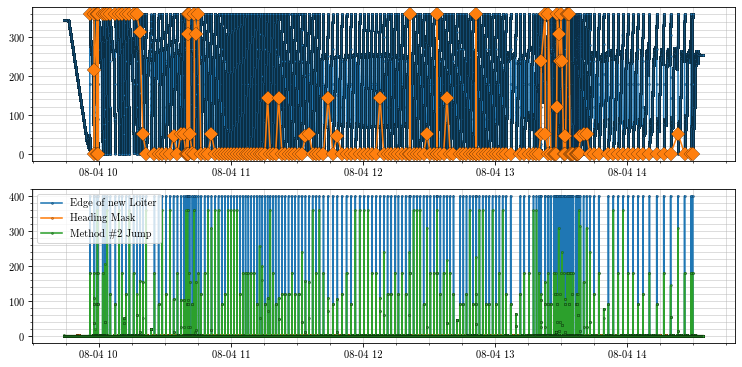

In [14]:
fig = plt.figure(figsize=(10,5), dpi=75)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.Heading)
ax1.plot(df.index[edge_mask == True], df.Heading[edge_mask == True], marker='D', markersize=10, linestyle=None)

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, edge_mask*400, label='Edge of new Loiter')
ax2.plot(df.index, heading_mask, label="Heading Mask")
ax2.plot(df.index, jump, label="Method #2 Jump")
ax2.legend(loc='upper left')
plt.show()

In [15]:
def show_loiters(loiter_numbers, df, loiter_times):
    fig, axs = plt.subplots(int(np.ceil(loiter_numbers.size / 4)), 4)
    axs = axs.flatten()

    for i, loiter_number in enumerate(loiter_numbers):
        mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_number], loiter_times.index[loiter_number+1])
        segment = df[mask]
        #durations = loiter_times.index.to_series().diff()
        
        axs[i].plot(segment.Latitude, segment.Longitude)
        axs[i].set_title("L#: " + str(loiter_number) + " T: " + str(loiter_times.index[loiter_number].hour)+':'+str(loiter_times.index[loiter_number].minute)+':'+str(loiter_times.index[loiter_number].second))

    fig.set_size_inches(10, 15)
    plt.show()

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

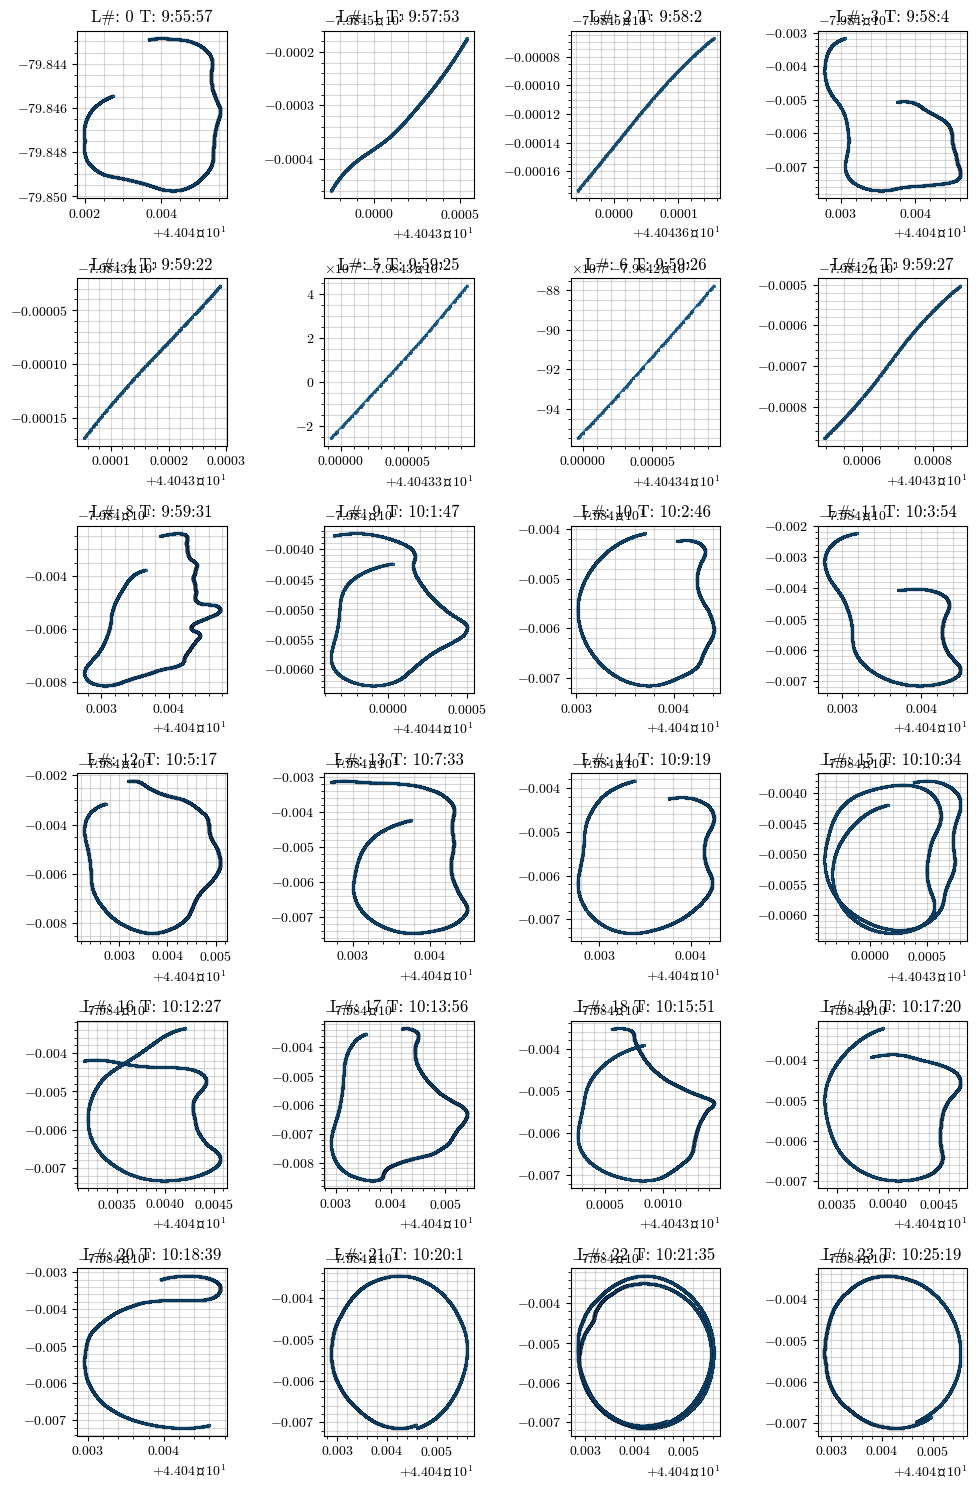

In [16]:
loiter_numbers = np.arange(0, 24) # Selecting the nth loiter of the flight for analysis #
show_loiters(loiter_numbers, df, loiter_times)

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

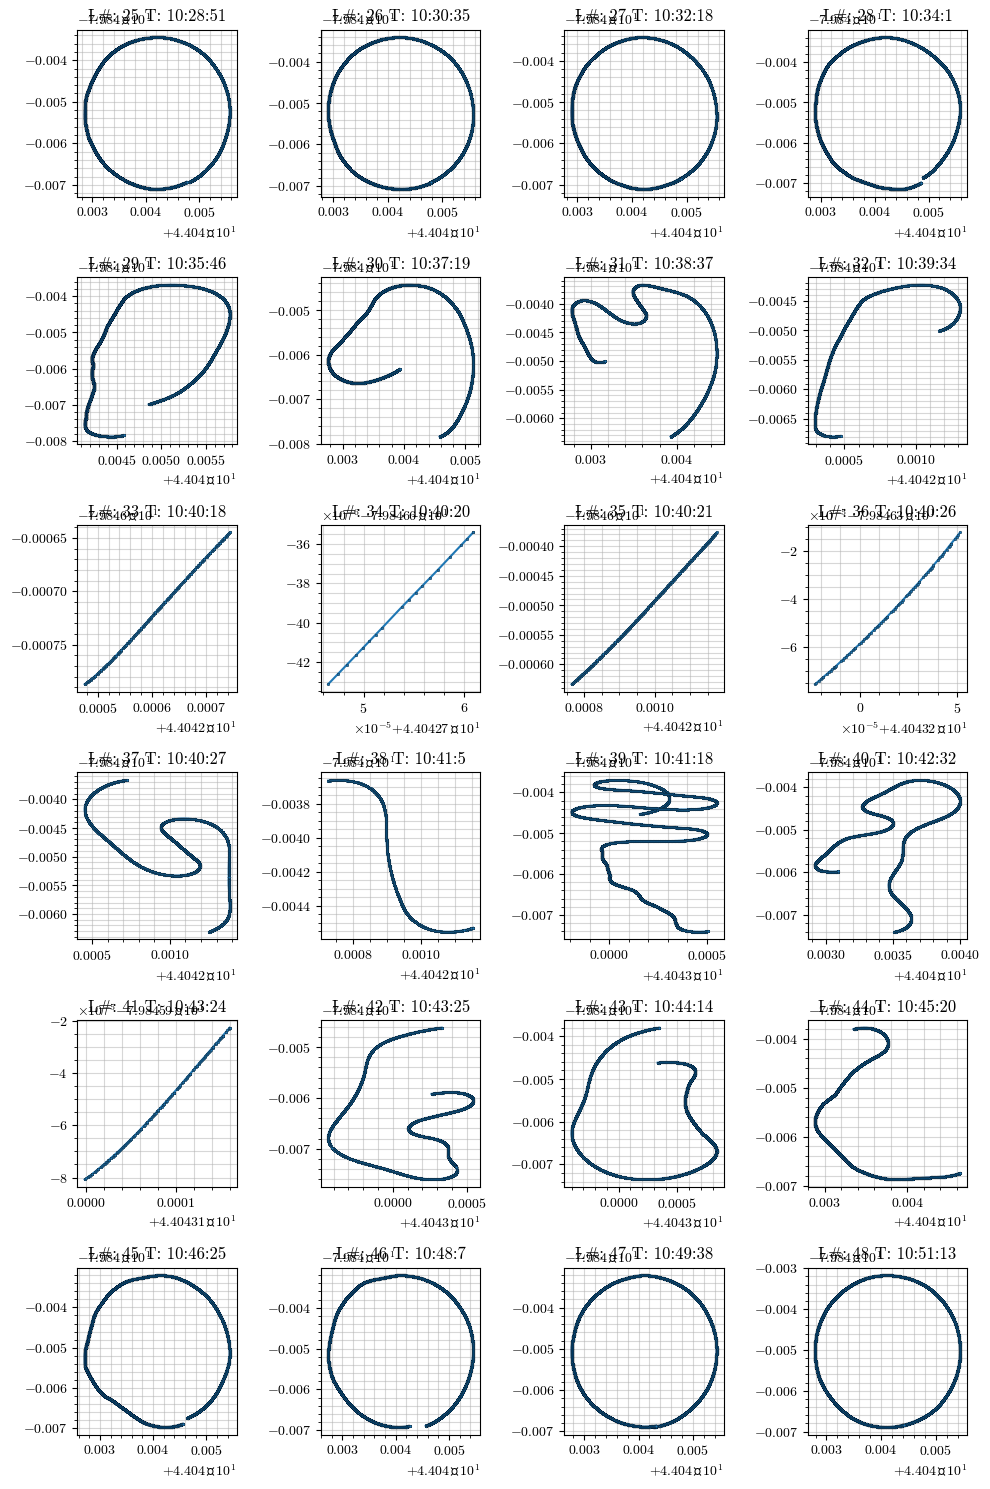

In [17]:
loiter_numbers = np.arange(25, 49) # Selecting the nth loiter of the flight for analysis #
show_loiters(loiter_numbers, df, loiter_times)

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


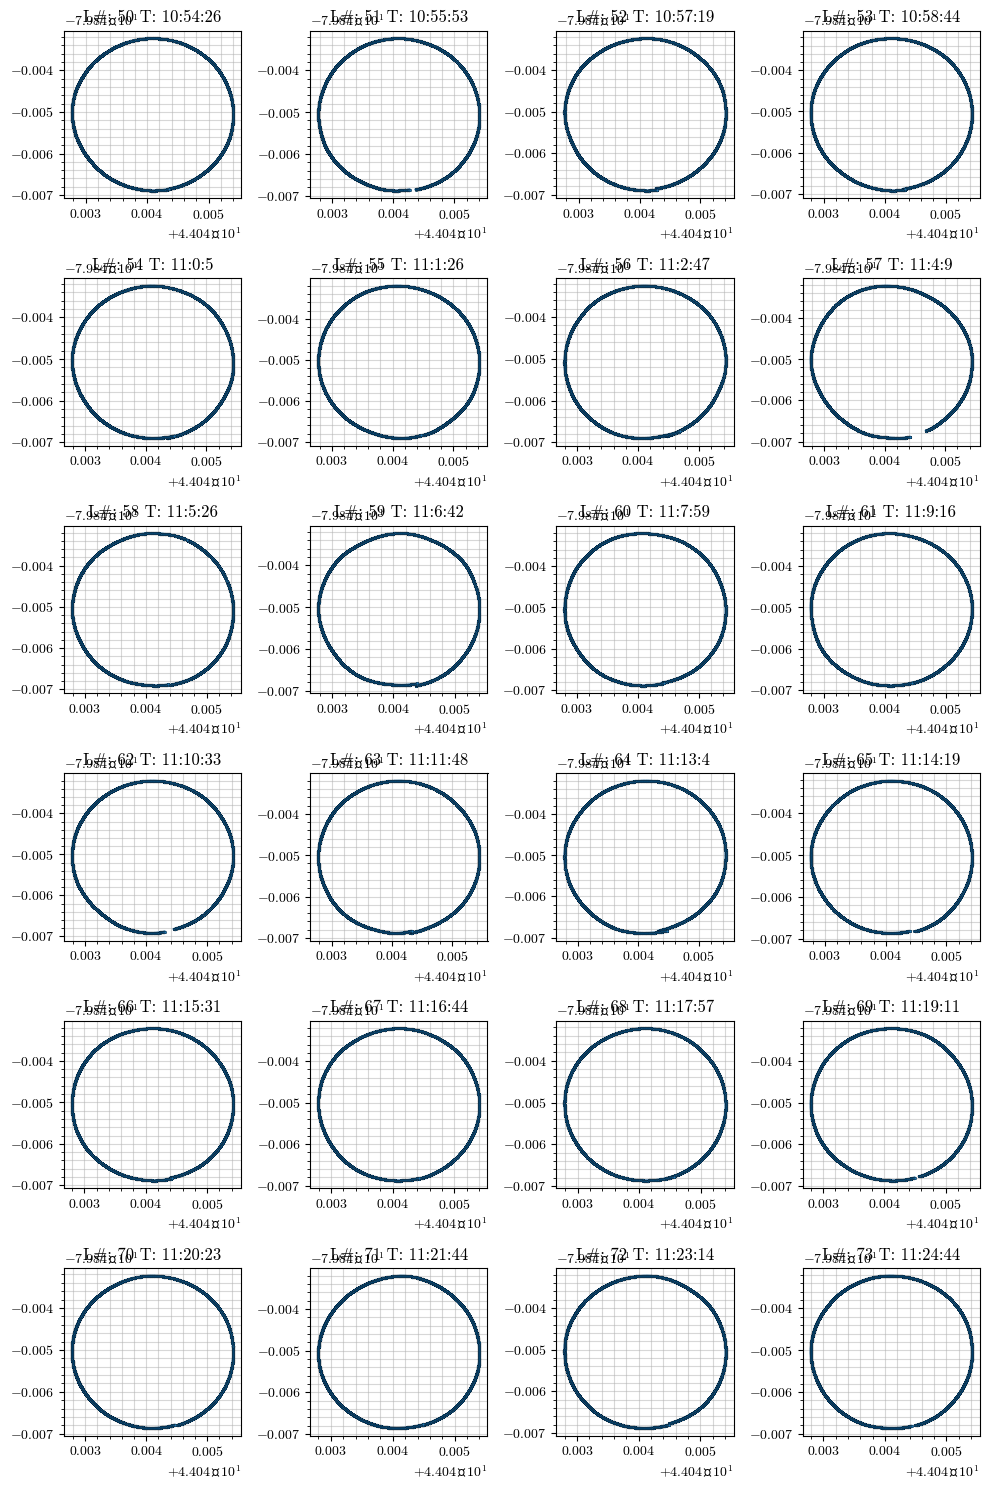

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


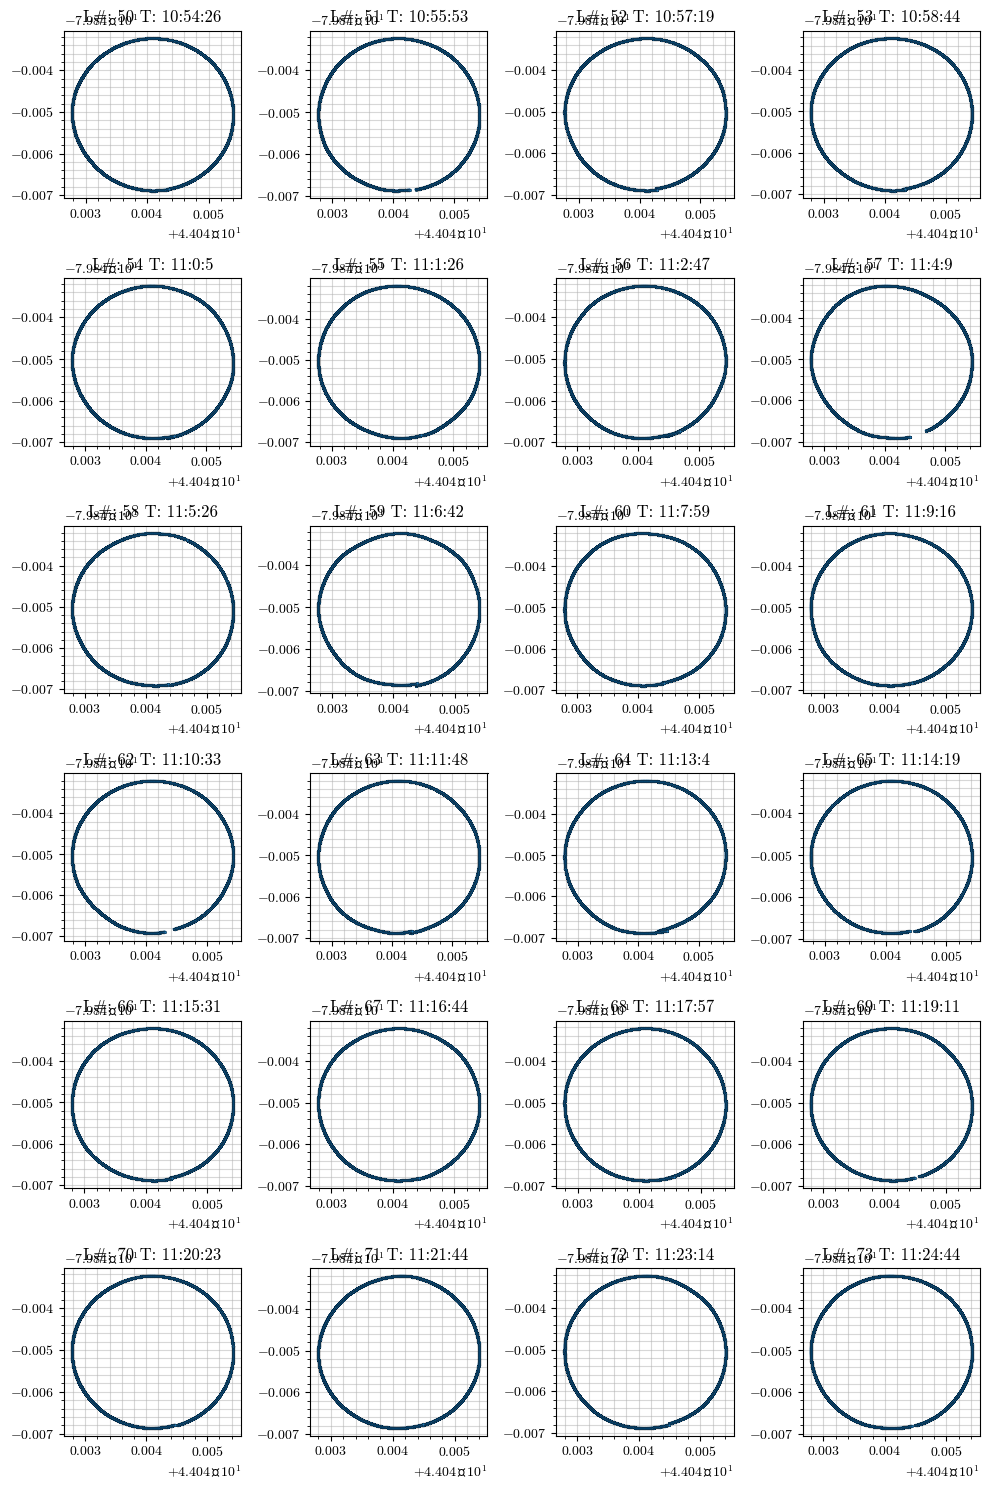

In [18]:
loiter_numbers = np.arange(50, 74) # Selecting the nth loiter of the flight for analysis #
show_loiters(loiter_numbers, df, loiter_times)

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


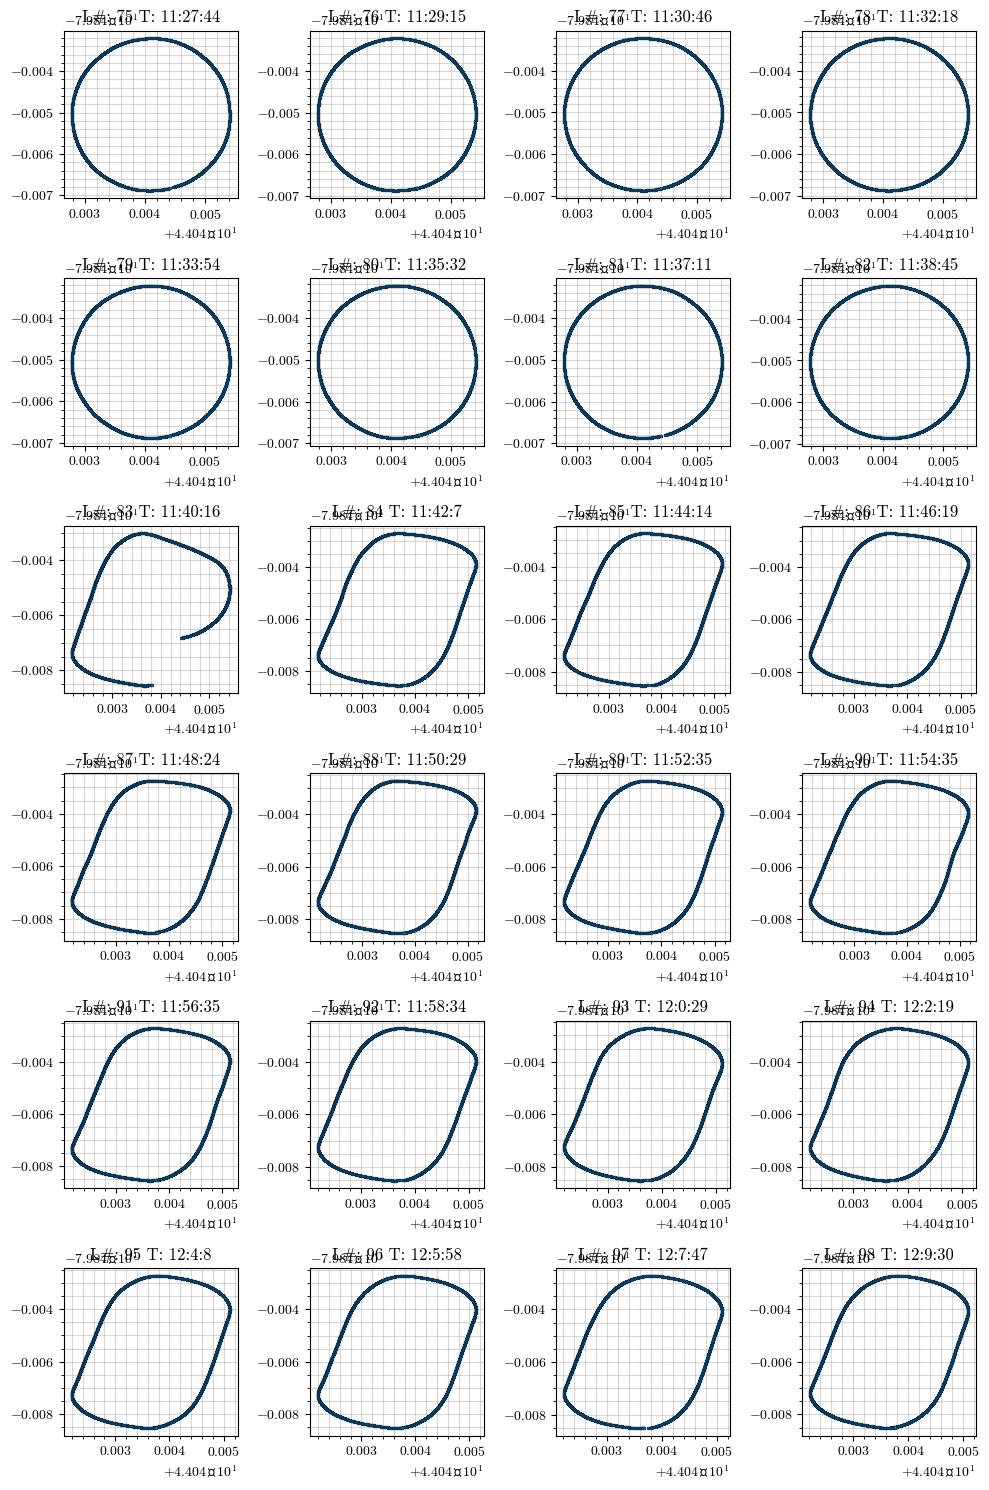

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


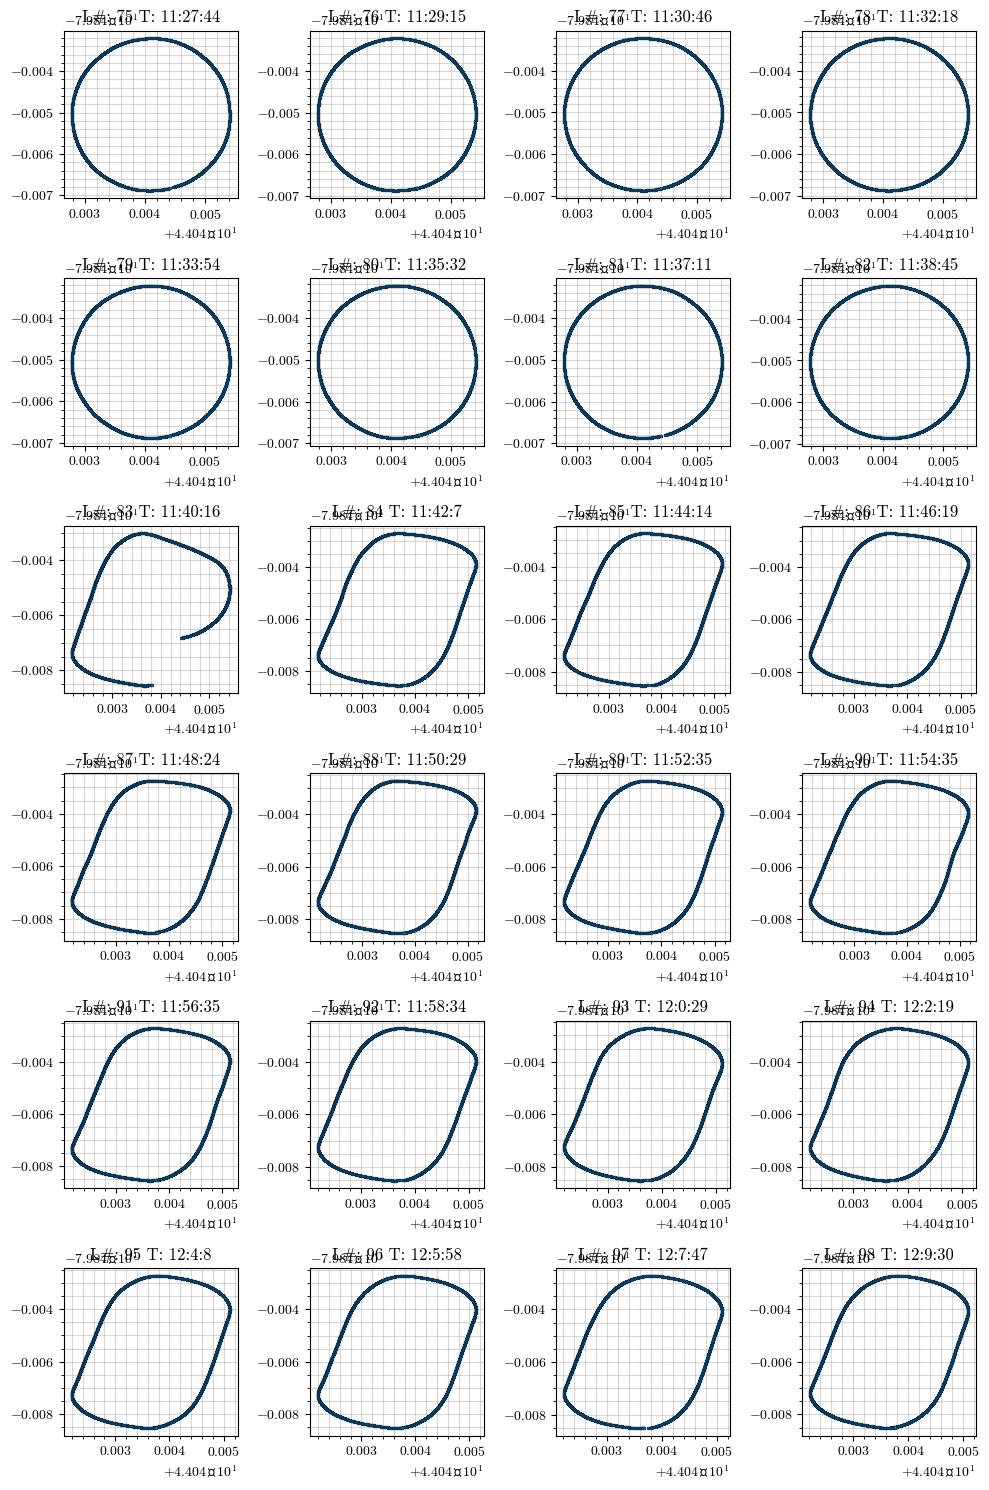

In [19]:
loiter_numbers = np.arange(75, 99) # Selecting the nth loiter of the flight for analysis #
show_loiters(loiter_numbers, df, loiter_times)

## Getting Constant Demanded Airspeed Loiter Numbers

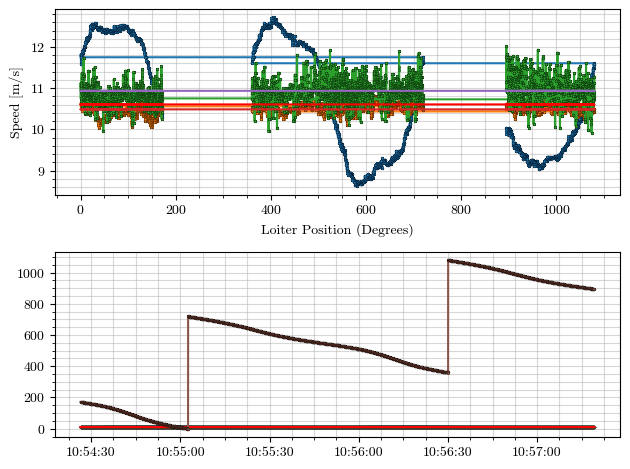

In [83]:
loiter_numbers = np.arange(50, 52)
[theta_complete, segments_complete] = collect_loiterdata(loiter_numbers, loiter_times, df)

[fig,axs] = plt.subplots(2, 1)
axs[0].plot(theta_complete, segments_complete.Groundspeed_GPS, label="Ground Speed")
axs[0].plot(theta_complete, segments_complete.Airspeed_Sensor0, label="Sensor 0 Airspeed")
axs[0].plot(theta_complete, segments_complete.Airspeed_Sensor1, label="Sensor 1 Airspeed")
axs[0].plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor0), marker='', linestyle='-', label="Average Airspeed Sensor 0")
axs[0].plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor1), marker='', linestyle='-', label="Average Airspeed Sensor 1")

axs[0].plot(theta_complete, segments_complete.Airspeed_Demanded, marker='', color='red', label="Demanded Airspeed")

axs[0].set_xlabel("Loiter Position (Degrees)")
axs[0].set_ylabel("Speed [m/s]")

axs[1].plot(segments_complete.index, segments_complete.Groundspeed_GPS, label="Ground Speed")
axs[1].plot(segments_complete.index, segments_complete.Airspeed_Sensor0, label="Sensor 0 Airspeed")
axs[1].plot(segments_complete.index, segments_complete.Airspeed_Sensor1, label="Sensor 1 Airspeed")
axs[1].plot(segments_complete.index, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor0), marker='', linestyle='-', label="Average Airspeed Sensor 0")
axs[1].plot(segments_complete.index, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor1), marker='', linestyle='-', label="Average Airspeed Sensor 1")
axs[1].plot(segments_complete.index, segments_complete.Airspeed_Demanded, marker='', color='red', label="Demanded Airspeed")

axs[1].plot(segments_complete.index, theta_complete)

plt.show()

In [48]:
Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])
groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])

In [49]:
pop_result

array([ 1.51234511, 11.91672737,  0.38623217])

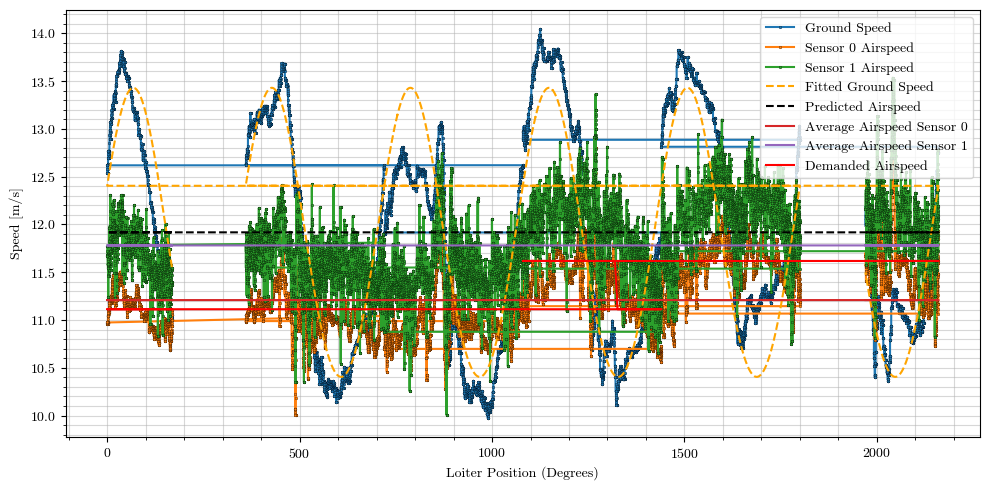

In [50]:
plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS, label="Ground Speed")
plt.plot(theta_complete, segments_complete.Airspeed_Sensor0, label="Sensor 0 Airspeed")
plt.plot(theta_complete, segments_complete.Airspeed_Sensor1, label="Sensor 1 Airspeed")
plt.plot(theta_complete, groundspeed_fit, marker='', linestyle='--', color='orange', label="Fitted Ground Speed")
plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * pop_result[1], marker='', linestyle='--', color='black', label="Predicted Airspeed")
plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor0), marker='', linestyle='-', label="Average Airspeed Sensor 0")
plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor1), marker='', linestyle='-', label="Average Airspeed Sensor 1")

plt.plot(theta_complete, segments_complete.Airspeed_Demanded, marker='', color='red', label="Demanded Airspeed")

plt.legend(loc="upper right")
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Speed [m/s]")
plt.show()